In [1]:
import os
import datetime
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data frames

log_pr = pd.read_pickle("./log_price.df")
volu = pd.read_pickle("./volume_usd.df")

In [3]:
log_pr

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2021-07-01 00:00:00,0.000051,-0.002754,-0.001690,-0.000106,0.002195,0.000217,-0.001661,0.000492,-0.000917,-0.000769
2021-07-01 00:01:00,-0.002184,-0.001334,0.000652,0.000254,0.000969,0.000204,-0.002689,0.001095,-0.000665,-0.000493
2021-07-01 00:02:00,-0.000792,0.001095,0.001293,0.000294,-0.003068,0.000814,-0.005329,0.000172,0.002367,0.000202
2021-07-01 00:03:00,-0.000399,0.000931,0.001274,-0.000695,-0.002457,0.000626,-0.002712,0.000216,0.003020,0.000335
2021-07-01 00:04:00,-0.001120,0.001134,0.001266,-0.000583,-0.003706,0.000280,-0.004193,0.000299,0.002340,0.000187
...,...,...,...,...,...,...,...,...,...,...
2021-12-31 23:55:00,0.202473,-0.953688,1.822158,-0.014819,-0.455037,-0.433889,-0.248988,-0.444827,0.051673,-0.097036
2021-12-31 23:56:00,0.202848,-0.953987,1.822320,-0.014359,-0.455589,-0.433965,-0.249405,-0.444581,0.051369,-0.097438
2021-12-31 23:57:00,0.203726,-0.954003,1.822973,-0.014348,-0.455433,-0.434181,-0.250450,-0.444742,0.051289,-0.097625


<AxesSubplot:xlabel='timestamp'>

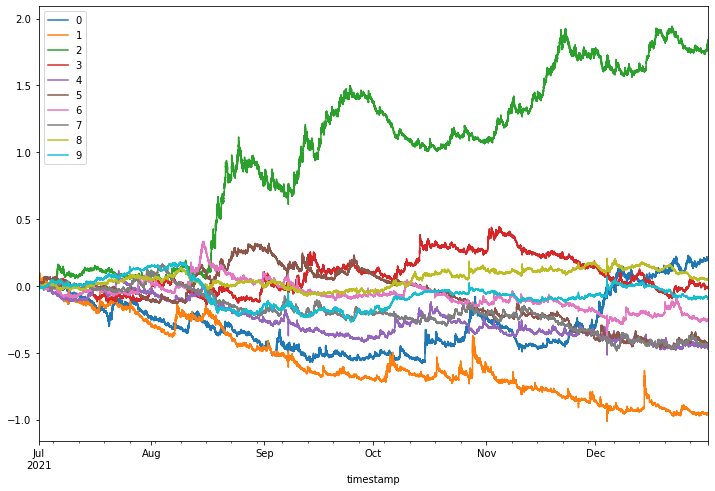

In [4]:
# Check the log-prices of the 10 assets

log_pr.plot(figsize=(12, 8))

<AxesSubplot:xlabel='timestamp'>

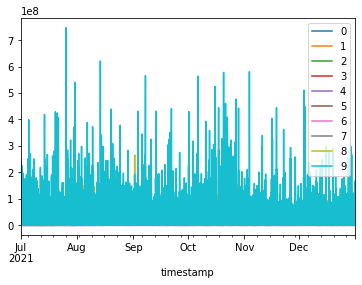

In [5]:
volu.plot()

# Construct Features

## Relative Strength Index (RSI)

In [6]:
def RSI(df, window_length):
    # transform log-price to price
    df = np.exp(df)
    # Calculate Price Differences
    df['diff'] = df.diff(1)
    # Calculate Avg. Gains/Losses
    df['gain'] = df['diff'].clip(lower=0)
    df['loss'] = df['diff'].clip(upper=0).abs()
    # Get initial Averages
    df['avg_gain'] = df['gain'].rolling(window=window_length, min_periods=window_length).mean()
    #[:window_length+1]
    df['avg_loss'] = df['loss'].rolling(window=window_length, min_periods=window_length).mean()
    #[:window_length+1]
    # Get WMS averages
    # Average Gains
    for i, row in enumerate(df['avg_gain'].iloc[window_length+1:]):
        df['avg_gain'].iloc[i + window_length + 1] =\
            (df['avg_gain'].iloc[i + window_length] *
             (window_length - 1) +
             df['gain'].iloc[i + window_length + 1])\
            / window_length
    # Average Losses
    for i, row in enumerate(df['avg_loss'].iloc[window_length+1:]):
        df['avg_loss'].iloc[i + window_length + 1] =\
            (df['avg_loss'].iloc[i + window_length] *
             (window_length - 1) +
             df['loss'].iloc[i + window_length + 1])\
            / window_length
    # Calculate RS Values
    df['rs'] = df['avg_gain'] / df['avg_loss']
    # Calculate RSI Values
    df['rsi'] = 100 - (100 / (1.0 + df['rs']))
    return (df['rsi'])


In [7]:
RSI = log_pr.apply(RSI, window_length=10)

In [ ]:
RSI.to_pickle("RSI.df")

## moving average convergence divergence (MACD)

In [ ]:
# def MACD(df,timewindow1 = 26,timewindow2 = 12):
#     # transform log-price to price
#     df = np.exp(df)
#     # Get the 26-day EMA of the closing price
#     k = df.ewm(span=timewindow1, adjust=False, min_periods=timewindow1).mean()
#     # Get the 12-day EMA of the closing price
#     d = df.ewm(span=timewindow2, adjust=False, min_periods=timewindow2).mean()
#     # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
#     macd = k - d
#     print(macd)
#     # Get the 9-Day EMA of the MACD for the Trigger line
#     macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
#     # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
#     macd_h = macd - macd_s
#     df['macd'] = df.index.map(macd)
#     df['macd_h'] = df.index.map(macd_h)
#     df['macd_s'] = df.index.map(macd_s)
#     return (df[['macd','macd_h','macd_s']])

In [8]:
macd_df = pd.DataFrame()
macd_s_df = pd.DataFrame()
macd_h_df = pd.DataFrame()

In [9]:
for i in range(10):
    df = np.exp(log_pr[i])
    # Get the 26-day EMA of the closing price
    k = df.ewm(span=26, adjust=False, min_periods=26).mean()
    # Get the 12-day EMA of the closing price
    d = df.ewm(span=12, adjust=False, min_periods=12).mean()
    # Subtract the 26-day EMA from the 12-Day EMA to get the MACD
    macd = k - d
    macd_df[i] = macd
    #Get the 9-Day EMA of the MACD for the Trigger line
    macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
    macd_s_df[i] = macd_s
    # Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
    macd_h = macd - macd_s
    macd_h_df[i] = macd_h
    # return (df[['macd','macd_h','macd_s']])

In [ ]:
macd_df.to_pickle("macd.df")
macd_s_df.to_pickle("macd_s.df")
macd_h_df.to_pickle("macd_h.df")

## Volume and Log Price Ratios

In [10]:
def getVolPriceRatios(A, B, priceWindow = 5, volWindow = 5):  # Window here is in minutes
  PriceFeature = A.rolling(priceWindow).sum()
  VolFeature = B.rolling(volWindow).sum()

  PriceFeature = A/PriceFeature
  VolFeature = B/VolFeature

  return PriceFeature, VolFeature


PriceRatio, VolRatio = getVolPriceRatios(log_pr, volu)

In [11]:
PriceRatio.to_pickle("logpriceRatio.df")
VolRatio.to_pickle("volRatio.df")

## Moving averages and difference between short/long-term

In [12]:
# moving averages of different time span
# and differences between short-term and long-term
# moving averages of log-price (if dif is set to True)
def mov_avg(A, B, window_interval=10, dif=True):
    j = window_interval
    
    # 30 minutes
    pr_avg_0 = A.rolling(window=30).mean().iloc[29::j, :]
    vo_avg_0 = B.rolling(window=30).mean().iloc[29::j, :]
    
    # 1 hour (60 minutes)
    pr_avg_1 = A.rolling(window=60).mean().iloc[59::j, :]
    vo_avg_1 = B.rolling(window=60).mean().iloc[59::j, :]
    
    # 3 hours (180 minutes)
    pr_avg_3 = A.rolling(window=180).mean().iloc[179::j, :]
    vo_avg_3 = B.rolling(window=180).mean().iloc[179::j, :]
    
    # stack the dfs together
    pr_avg = pd.concat([pr_avg_0, pr_avg_1, pr_avg_3], axis=0)
    vo_avg = pd.concat([vo_avg_0, vo_avg_1, vo_avg_3], axis=0)
    
    if dif:
        pr_dif = pd.concat([
            pr_avg_0.iloc[30:, :] - pr_avg_1, 
            pr_avg_0.iloc[150:, :] - pr_avg_3,
            pr_avg_1.iloc[120:, :] - pr_avg_3,
        ], axis=0)
        return (pr_avg, vo_avg, pr_dif)
    
    return (pr_avg, vo_avg)

In [15]:
pr_avg, vo_avg, pr_dif = mov_avg(log_pr, volu, 1, True)
pr_avg.to_pickle("MovingAverage_logprice.df")
vo_avg.to_pickle("MovingAverage_volumn.df")
pr_dif.to_pickle("MovAvgDif_logprice.df")

## Minute changes in log-price

In [20]:
# changes in log-price
def cha_pr(A):
    # return: a scaler of the minute changes in log-price
    # we can construct more complicated features based on the relative change
    return (A.iloc[1:, :] - A.iloc[:-1, :])

In [21]:
cha_in_pr = cha_pr(log_pr)
cha_in_pr.to_pickle("ChangeInlogprice.df")

## Z-score of log-price

In [18]:
# z-score of log-price
def z_score_pr(A):
    # return: a 3 x 10 dataframe of z-scores based on
    # the moving average log-price of 30min, 1h, and 3h
    
    # moving averages of 30 minutes
    pr_avg_0 = A.rolling(window=30).mean().iloc[29:, :]
    
    # 1 hour (60 minutes)
    pr_avg_1 = A.rolling(window=60).mean().iloc[59:, :]
    
    # 3 hours (180 minutes)
    pr_avg_3 = A.rolling(window=180).mean().iloc[179:, :]
    
    z0 = (A.iloc[-1, :] - pr_avg_0.iloc[-1, :]) / pr_avg_0.std()
    z1 = (A.iloc[-1, :] - pr_avg_1.iloc[-1, :]) / pr_avg_1.std()
    z3 = (A.iloc[-1, :] - pr_avg_3.iloc[-1, :]) / pr_avg_3.std()
    return (pd.concat([z0, z1, z3], axis=1).T)

In [19]:
z_score = z_score_pr(log_pr)
z_score.to_pickle("zscore.df")

In [ ]:
# An example of get_r_hat

def get_r_hat(A, B): 
    """
        A: 1440-by-10 dataframe of log prices with columns log_pr_0, ... , log_pr_9
        B: 1440-by-10 dataframe of trading volumes with columns volu_0, ... , volu_9    
        return: a numpy array of length 10, corresponding to the predictions for the forward 30-minutes returns of assets 0, 1, 2, ..., 9
    """
    
    return -(A.iloc[-1] - A.iloc[-30]).values # Use the negative 30-minutes backward log-returns to predict the 30-minutes forward log-returns

In [ ]:
# Generate r_hat every 10 minutes

t0 = time.time()
dt = datetime.timedelta(days=1)
r_hat = pd.DataFrame(index=log_pr.index[30::10], columns=np.arange(10), dtype=np.float64)
for t in log_pr.index[30::10]: # compute the predictions every 10 minutes
    r_hat.loc[t, :] = get_r_hat(log_pr.loc[(t - dt):t], volu.loc[(t - dt):t])
t_used = time.time() - t0
print(t_used)
    

In [ ]:
# Compute true forward log_returns every 10 minutes
r_fwd = (log_pr.shift(-30) - log_pr).iloc[30::10].rename(columns={f"log_pr_{i}": i for i in range(10)})


In [ ]:
# Correlation for every asset
r_fwd.corrwith(r_hat)

In [ ]:
# Overall correlation (The ranking is based on this metric on the testing dataset)

r_fwd_all = r_fwd.iloc[:-3].values.ravel() # the final 3 rows are NaNs. 
r_hat_all = r_hat.iloc[:-3].values.ravel()
np.corrcoef(r_fwd_all, r_hat_all)[0, 1]